In [56]:
import numpy as np
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as mc
from matplotlib import pyplot as plt

In [57]:
p1 = (0, 0, 0)
p2 = (60e-9, 60e-9, 10e-9)
region = df.Region(p1=p1, p2=p2)
subregions={'bottom': df.Region(p1=(0, 0, 0), p2=(60e-9, 60e-9, 4e-9)),
            'spacer': df.Region(p1=(0, 0, 4e-9), p2=(60e-9, 60e-9, 6e-9)),
            'top': df.Region(p1=(0, 0, 6e-9), p2=(60e-9, 60e-9, 10e-9))}
mesh = df.Mesh(region=region, n=(20, 20, 5), subregions=subregions)

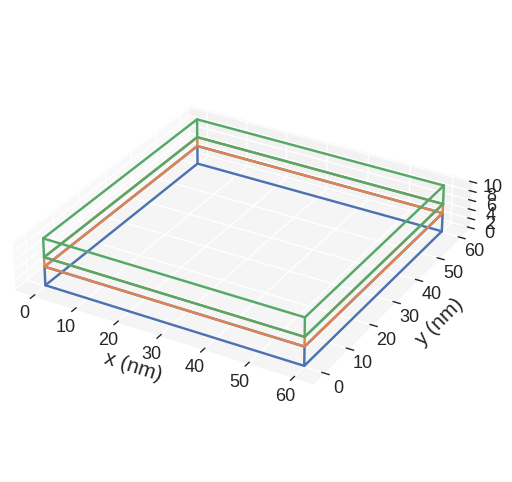

In [58]:
mesh.mpl.subregions()

In [59]:
sigma2 = [0, -0.1, -0.05, -0.01]

for sigma2_ in sigma2:
    system = mm.System(name='biqudratic')
    system.energy = (mm.Exchange(A=15e-12) +
                    mm.RKKY(sigma=0, sigma2=sigma2_, subregions=['bottom', 'top']) +
                    mm.UniaxialAnisotropy(K=3.7e3, u=(1, 0, 0))+
                        mm.Demag())

    norm = {'bottom': 1300e3, 'top': 1300e3, 'spacer': 0}
    M_dir = {'bottom': (0.99, 0.01, 0), 'top': (-.99, 0.01, 0), 'spacer': (0, 0, 1)}

    system.m = df.Field(mesh, nvdim=3, value=M_dir, norm=norm, valid='norm')

    md = mc.MinDriver()
    md.drive(system)

    Hmin = (0, 0, -5/mm.consts.mu0)
    Hmax = (0, 0, 5/mm.consts.mu0)
    n=401

    hd = mc.HysteresisDriver()
    hd.drive(system, Hmin=Hmin, Hmax=Hmax, n=n)

    mz = system.table.data.mz.to_numpy()
    Bz = system.table.data.Bz_hysteresis.to_numpy()

    np.save(f"ref2/oommf_hysteresis_mz_sigma2_{sigma2_}.npy", mz)
    np.save(f"ref2/oommf_hysteresis_Bz_sigma2_{sigma2_}.npy", Bz)

Running OOMMF (TclOOMMFRunner)[2024/03/26 14:06]... (0.4 s)
Running OOMMF (TclOOMMFRunner)[2024/03/26 14:06]... (26.5 s)
Running OOMMF (TclOOMMFRunner)[2024/03/26 14:06]... (0.3 s)
Running OOMMF (TclOOMMFRunner)[2024/03/26 14:06]... (130.0 s)
Running OOMMF (TclOOMMFRunner)[2024/03/26 14:09]... (0.3 s)
Running OOMMF (TclOOMMFRunner)[2024/03/26 14:09]... (101.8 s)
Running OOMMF (TclOOMMFRunner)[2024/03/26 14:10]... (0.2 s)
Running OOMMF (TclOOMMFRunner)[2024/03/26 14:10]... (64.2 s)


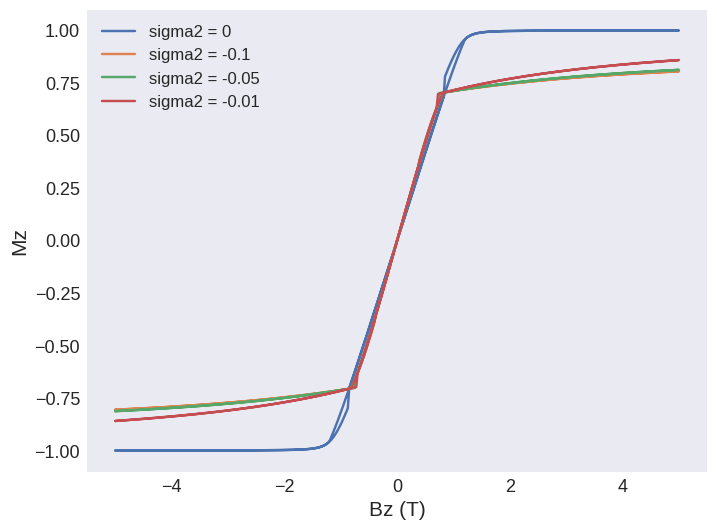

In [61]:
sigma2_oommf = [0, -0.1, -0.05, -0.01]
sigma2 = [0, -0.1, -0.05, -0.01]


B_oommf = np.zeros((4, 801))
M_oommf = np.zeros((4, 801))

for i, sigma2_ in enumerate(sigma2_oommf):
    B_oommf[i] = np.load(f"ref2/oommf_hysteresis_Bz_sigma2_{sigma2_}.npy")/1000
    M_oommf[i] = np.load(f"ref2/oommf_hysteresis_mz_sigma2_{sigma2_}.npy")

    plt.plot(B_oommf[i], M_oommf[i], label = f"sigma2 = {sigma2[i]}")

plt.xlabel("Bz (T)")
plt.ylabel("Mz")
plt.legend()
# plt.xlim(-2, 2)